# bTB Quick Insights and Trends
This notebook computes prevalence, top correlated features, seasonal trends, postcode hotspots, and attempts a simple logistic model for feature importance. Open and run the cells in order.

Overall TB prevalence: 5.36% of farms
Top numeric features correlated with TB_Positive:
Proximity_To_Known_Badger_Sett_Km    0.385677
Farm_Size_Acres                      0.039120
Herd_Size                            0.023966
Avg_Temperature_3M_Prior_C           0.009616
Biosecurity_Score                    0.005455
Cattle_Movement_In_Last_Year         0.002107
Days_Since_Last_Test                 0.002068
Avg_Rainfall_3M_Prior_MM             0.000567
Proximity_To_Other_Farms_Km          0.000456
Name: TB_Positive, dtype: float64
Prevalence by Test_Season (%):
Test_Season
August       6.429392
September    6.072874
October      5.868815
June         5.771496
December     5.714286
July         5.372405
May          5.317919
January      5.294826
November     5.119454
April        5.024510
February     4.600812
March        3.745743
Name: TB_Positive, dtype: float64


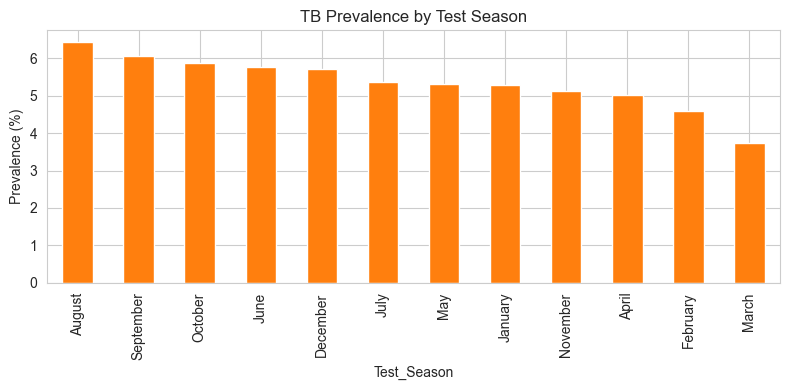

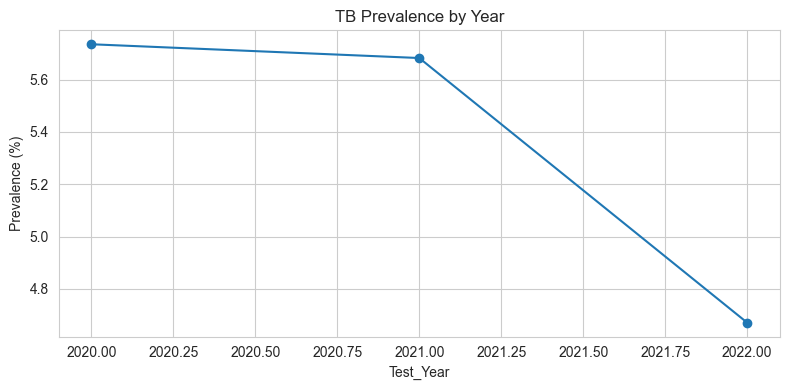

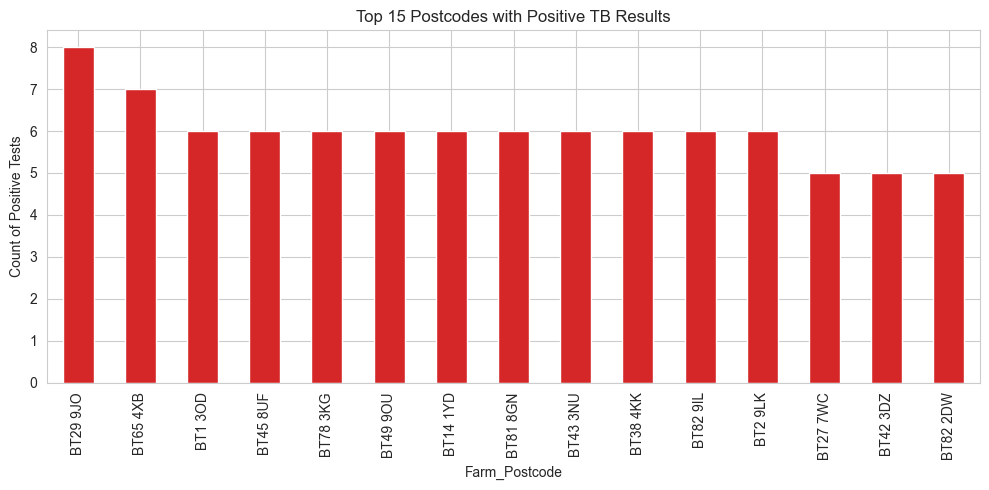

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
# Load the same dataset used in your walkthrough (path may need adjusting)
df = pd.read_csv(r'C:/Users/jmcrawford/OneDrive - Deloitte (O365D)/QUB Analytathon/farm_data.csv')
# Create binary target column (1 = positive) robustly
if 'Test_Result' in df.columns:
    df['TB_Positive'] = df['Test_Result'].astype(str).str.contains('Positive', case=False, na=False).astype(int)
else:
    raise ValueError('Test_Result column is required for this analysis')
# Prevalence
prevalence = df['TB_Positive'].mean() * 100
print(f'Overall TB prevalence: {prevalence:.2f}% of farms')
# Prepare numerical columns for correlation and modelling
candidate_numerical = ['Herd_Size', 'Farm_Size_Acres', 'Biosecurity_Score', 'Cattle_Movement_In_Last_Year',
                       'Proximity_To_Other_Farms_Km', 'Avg_Rainfall_3M_Prior_MM', 'Avg_Temperature_3M_Prior_C',
                       'Badger_Density_Score_Local', 'Proximity_To_Known_Badger_Sett_Km', 'Days_Since_Last_Test']
present_numerical = [c for c in candidate_numerical if c in df.columns]

# Handle Biosecurity_Score conversion early
if 'Biosecurity_Score' in present_numerical:
    try:
        df['Biosecurity_Score'] = pd.to_numeric(df['Biosecurity_Score'])
    except Exception:
        mapping = {'Low':1,'Medium':2,'High':3,'Excellent':4,'Poor':0}
        df['Biosecurity_Score'] = df['Biosecurity_Score'].map(mapping).fillna(df['Biosecurity_Score'].median())

# Ensure all present_numerical columns are actually numeric, filtering out any that aren't
present_numerical = [c for c in present_numerical if pd.api.types.is_numeric_dtype(df[c])]

# Top correlated numeric features with TB_Positive (absolute corr)
if present_numerical:
    corr_df = df[present_numerical + ['TB_Positive']].corr().abs()['TB_Positive'].drop('TB_Positive').sort_values(ascending=False)
    print('Top numeric features correlated with TB_Positive:')
    print(corr_df.head(10))
else:
    print('No numerical columns available for correlation analysis.')
# Prevalence by Test_Season (if present)
if 'Test_Season' in df.columns:
    season = df.groupby('Test_Season')['TB_Positive'].mean().sort_values(ascending=False) * 100
    print('Prevalence by Test_Season (%):')
    print(season)
    plt.figure(figsize=(8,4))
    season.plot(kind='bar', color='C1')
    plt.ylabel('Prevalence (%)')
    plt.title('TB Prevalence by Test Season')
    plt.tight_layout()
    plt.show()
# Trend by year if Test_Date exists
if 'Test_Date' in df.columns:
    df['Test_Date'] = pd.to_datetime(df['Test_Date'], errors='coerce')
    if df['Test_Date'].notna().any():
        df['Test_Year'] = df['Test_Date'].dt.year
        yearly = df.groupby('Test_Year')['TB_Positive'].mean() * 100
        plt.figure(figsize=(8,4))
        yearly.plot(marker='o')
        plt.ylabel('Prevalence (%)')
        plt.title('TB Prevalence by Year')
        plt.tight_layout()
        plt.show()
# Top postcodes with positive results (top 15)
if 'Farm_Postcode' in df.columns:
    tb_by_postcode = df[df['TB_Positive'] == 1]['Farm_Postcode'].value_counts().nlargest(15)
    if not tb_by_postcode.empty:
        plt.figure(figsize=(10,5))
        tb_by_postcode.plot(kind='bar', color='C3')
        plt.title('Top 15 Postcodes with Positive TB Results')
        plt.ylabel('Count of Positive Tests')
        plt.tight_layout()
        plt.show()
    else:
        print('No positive TB test results found to analyse by postcode.')

In [5]:
# Attempt a simple logistic regression to assess feature importance (if sklearn available)
try:
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_auc_score
    if not present_numerical:
        print('No numerical features to train a model.')
    else:
        X = df[present_numerical].copy()
        # Simple numeric imputation: median
        X = X.fillna(X.median())
        y = df['TB_Positive']
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_s, y_train)
        y_pred_proba = model.predict_proba(X_test_s)[:,1]
        auc = roc_auc_score(y_test, y_pred_proba)
        coefs = pd.Series(model.coef_[0], index=present_numerical).abs().sort_values(ascending=False)
        print(f'Logistic regression ROC AUC: {auc:.3f}')
        print('Top features by absolute coefficient:')
        print(coefs.head(10))
except Exception as e:
    print('Could not run logistic regression (missing package or other error):', e)

Logistic regression ROC AUC: 0.913
Top features by absolute coefficient:
Proximity_To_Known_Badger_Sett_Km    2.998033
Farm_Size_Acres                      0.087197
Avg_Temperature_3M_Prior_C           0.081297
Herd_Size                            0.077208
Days_Since_Last_Test                 0.059094
Cattle_Movement_In_Last_Year         0.038835
Avg_Rainfall_3M_Prior_MM             0.034630
Biosecurity_Score                    0.024138
Proximity_To_Other_Farms_Km          0.014799
dtype: float64
